<a href="https://colab.research.google.com/github/YCCS-Summer-2023-DDNMA/project/blob/main/ramesh_natarajan/JaxIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This introduction focuses on the key features of the Jax framework. 

No ML background is required or covered.

I suggest you start by connecting to a hosted runtime.  Click the "*connect*" button on the top right hand corner. Once a connection is established you can click on the  "*ram/disk*" button that appears,  and see if you can change to a gpu or tpu runtime instance. 

Ideally you should be connected to a TPU instance.  However if you are unable to provision a TPU instances then the section on parallelization using **pmap** *should not* be executed.

Date Updated: May 17, 2023
Author: Ramesh Natarajan


# Setup

Import jax library, report version, check runtime (follow the instructions in the previous cells to make sure that if possible the runtime is a gpu or tpu enable instance) 

In [1]:
import jax
import jax.numpy as jnp


# version 
print("jax version {}".format(jax.__version__))

# Check the jax backend
backend_platform = jax.lib.xla_bridge.get_backend().platform
print("jax backend {}".format(backend_platform ))

if backend_platform == 'gpu':
  !nvidia-smi



jax version 0.3.25
jax backend cpu


# Sections


## Jit and XLA

Jit provides op fusion and other compiler optimizations targeted to backend gpu/tpu architectures, but which can speedup computations even on cpu's.  

Python source is transformed to an intermediate representation (jaxpr) which is then compiler-optimized to generate the computation graph for fast execution.  

Jit optimizable code should be written using pure functions (that is, functions should not have global state or any side effects).

In [2]:
from jax import jit, make_jaxpr 

def f(x):
  # Element-wise ops see a large benefit from fusion when jitted
  return x * x * x * x

x = jnp.ones((5000, 5000))
%timeit  f(x) 

jit_f = jit(f)
%timeit jit_f(x)  
 
assert jnp.allclose(f(x), jit_f(x))

167 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.6 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Use only Pure functions (with no side effects)

jit recompilation will take place for every new instance of input shape and dtype in the function arguments

In [ ]:
# function with side effects (print statement)
def f(x):
  print('x', x)
  y = 2 * x
  print('y', y)
  return y

# version without jit, repeated calls execute the same way
print('non-jit version')
print("first call:")
print('f', f(2))
print("second call:")
print('f', f(2))

# print the jaxpr
print("\njaxpr (notice the print calls are not part of the lambda)")
print (make_jaxpr(f)(2))

# version without jit, repeated calls have different behavior
print('\njit version (jaxpr is converted to xla compiled code)')

print("first call:")
print('f', jit(f)(2))
print("second call:")
print('f', jit(f)(2))


non-jit version
first call:
x 2
y 4
f 4
second call:
x 2
y 4
f 4

 printing the jaxpr
x Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
y Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:i32[]. let b:i32[] = mul 2 a in (b,) }

jit version
first call:
x Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
y Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
f 4
second call:
f 4



## Numpy-compatible with some Gotchas
Jax is Numpy (with some gotchas: asynchronous execution, array mutation, index out of bounds, NaNs, special casting rules)

In [ ]:
import numpy as np

nsz1 = 4000
nsz2 = 4000

x = np.arange(nsz1*nsz2, dtype=np.float32)
x = x.reshape([nsz1, nsz2])

print("\n numpy execution")
%time result = (x @ x.T)

import jax.numpy as jnp

x = jnp.arange(nsz1*nsz2, dtype=jnp.float32)
x = x.reshape([nsz1, nsz2])

print("\n jax.numpy blocking call")
%time  result =(x @ x.T).block_until_ready() # without the block method python will return asynchronously

print("\n jax.numpy asynchronous call (incorrect value)")
%time  result =(x @ x.T) # this will be much faster but nothing will be calculated


 numpy execution
CPU times: user 992 ms, sys: 94.9 ms, total: 1.09 s
Wall time: 1.03 s

 jax.numpy blocking call
CPU times: user 8.01 ms, sys: 39.9 ms, total: 47.9 ms
Wall time: 48 ms

 jax.numpy asynchronous call
CPU times: user 478 µs, sys: 0 ns, total: 478 µs
Wall time: 488 µs


In [ ]:
print("array mutation with numpy")
a = np.ones((10,))
print(f"original array: {a}")
a[:3] = 0
print(f"in-place modified array: {a}")

print("\narray mutation not allowed with jax.numpy, new array created")
a2 = jnp.ones((10,))
print(f"original array: {a2}")
a2mod = a2.at[:3].set(0)
print(f"original array: {a2}")
print(f"modified array: {a2mod}")



array mutation with numpy
original array: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
in-place modified array: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]

array mutation not allowed with jax.numpy, new array created
original array: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
original array: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
modified array: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


## Batching and Vectorization (**vmap**)

You can easily go from single to multiple batched examples with improved performance on GPU's

In [ ]:
from jax import vmap,

# single example

x = jnp.arange(1,5)
w = jnp.arange(4,8) 
y = jnp.arange(10,11)

print(f"x:{x}, w:{w}, y:{y}")

def error(x, w, y):
  return jnp.array(y - jnp.dot(x, w))

err = error(x, w, y)

print(f"single example: {err}")

# multiplebatched example

batchsz = 8

xs = jnp.stack([x for _ in range(batchsz)])
ws = jnp.stack([w*i for i in range(batchsz)])
ys = jnp.stack([y for _ in range(batchsz)])


from jax import vmap

# vectorized along the batch dimension (first dimension by default)

verr = vmap(error)(xs, ws, ys)
print(f"batched example:\n{verr}")

# vectorized along the batch dimension with w not batched

verr2 = vmap(error, in_axes = [0, None, 0])(xs, w, ys)
print(f"batched example with w not batch:\n{verr2}")

x:[1 2 3 4], w:[4 5 6 7], y:[10]
single example: [-50]
batched example:[[  10]
 [ -50]
 [-110]
 [-170]
 [-230]
 [-290]
 [-350]
 [-410]
 [-470]
 [-530]]
batched example with w not batch:[[-50]
 [-50]
 [-50]
 [-50]
 [-50]
 [-50]
 [-50]
 [-50]
 [-50]
 [-50]]


## Parallelization (**pmap**)

Similar to vectorization with vmap, parallelization can be performed with pmap (for example, this works on the TPU-v4 which has multiple processors, along with collective communication primitives optimized for TPU-v4 processor interconnect). The execution with pmap and vmap can be nested.  

## Pseudo Random Number Generation

No global state for PRNG.  

Use separate keys to ensure independent random variates that are consistent with out-of-order parallel execution. 


In [ ]:
from jax import random


# the equivalent numpy code would have global state and the result will depend on the order of execution.
def unif(key): 
  return jax.random.uniform(key,shape=(3,))

def norm(key):
  return jax.random.normal(key, shape=(3,))

def foo(key): 
  subkey1, subkey2 = random.split(key, num=2) 
  a = unif(subkey1) 
  b =  norm(subkey2)
  return a+b

def bar(key): 
  subkey1, subkey2 = random.split(key, num=2) 
  b = norm(subkey2)
  a = unif(subkey1)
  return b+a

key = random.PRNGKey(0)

print(foo(key))
print(bar(key))

[ 1.6931263 -0.5262135 -0.2938828]
[ 1.6931263 -0.5262135 -0.2938828]


## Higher-order derivatives (**grad, jacfwd, jacrev** etc)

Easy to implement and makes use of tight Jax integration with autodiff

In [ ]:
from jax import grad, value_and_grad, hessian, jacfwd, jacrev, jvp, vjp

# higher order derivatives 
func = lambda x: x**3 + 2*x**2 - 3*x + 1

f = func
x = 0.0
for i in range(5):
  print(f"derivative of order {i} at {x}: {f(x)}")
  f = grad(f)

# partial derivatives

func2  = lambda x, y: (x+1)**2 + (y-1)**2

fx, fy = grad(func2, argnums= (0,1))(0.0,0.0)

print(f"gradients wrt x: {fx}, wrt y: {fy}")

# gradients of a multivariate scalar function

func3 = lambda x, w: jnp.dot(x, w)

sz = 5
subkey1, subkey2 = random.split(key, num=2) 
w = jax.random.normal(subkey1, shape=(sz,))
x = jax.random.normal(subkey2, shape=(sz,))

v, g = value_and_grad(func3)(x, w)

print(f"w:{w}")
print(f"value: {v}")
print(f"gradient: {g}")
assert np.allclose(g, w)

# jacobian of a a vector multivariate function

func4 = lambda x, W : jnp.dot(W, x)

szx = 5
szy = 4
subkey1, subkey2 = random.split(key, num=2) 
W = jax.random.normal(subkey1,shape=(szy, szx))
x = jax.random.normal(subkey2, shape=(szx,))
Jf = jacfwd(func4)(x, W)
Jr = jacrev(func4)(x, W)
assert jnp.allclose(Jf, Jr)
assert jnp.allclose(Jf, W)

# jacobian-vector products and vector-jacobian products 

szx = 5
szy = 4
subkey1, subkey2, subkey3 = random.split(key, num=3) 
W = jax.random.normal(subkey1,shape=(szy, szx))
x = jax.random.normal(subkey2, shape=(szx,))
u = jax.random.normal(subkey3, shape=(szy,))

func5 = lambda x: jnp.dot(W,x)

Jf = jacfwd(func5)(x)
assert jnp.allclose(Jf, W)
tmp1 = jnp.dot(u.T, Jf)
print(tmp1)
(val, jvp_fun) = vjp(func5, x)
tmp2 = jvp_fun(u)[0]
print(tmp2)

assert jnp.allclose(tmp1, tmp2)


[-1.2215806  -0.42417204 -0.02216347 -2.0033326  -1.072354  ]
[-1.2215806  -0.42417204 -0.02216347 -2.0033326  -1.072354  ]


## multidevice parallelism (**pmap**)

## Flexible containers for data structures (**pytrees**)

A Pytree is a container that recursively contains other Pytrees. Containers can be lists, tuples, and dicts.  The leaves of a Pytree are individual values/arrays used to store and access the parameters of machine learning models in a hierarchical structured form, that can easily be combined with Jax functions.

In [ ]:
from jax import tree_util

# create a  pytree

print("\ncreate a pytree")
tree1 = [jnp.array([10, 11, 12])]
tree2 = [1, {"k1": 2, "k2": (3, 4)}, 5]
tree = {"l1": tree1, "l2": tree2}
print(f"tree1: {tree1} \ntree2:{tree2} \ntree3: {tree}")
leaves = tree_util.tree_leaves(tree)
print('num leaves', len(leaves))
print(leaves)

# apply a function to all leaf elements in the tree

print("\nmodify: map function to all elements of a pytree)")
tree_mod = tree_util.tree_map(lambda x: jax.numpy.add(x,1), tree1)
print(f"\nmodified tree: {tree_mod}")

# combine 2 conforming trees

print("combine: map function to combine 2 pytrees)")

tree_comb = tree_util.tree_map(lambda x,y: jax.numpy.add(x, y), tree1, tree_mod)
print(f"\ncombined tree: {tree_comb}")

# flattening and unflattening

print("\nflattening and unflattening pytrees")
tree1 = [1, {"k1": 2, "k2": (3, 4)}, 5]
print(f"initial tree: {tree1}")
leaves, treedef = jax.tree_util.tree_flatten(tree1)
print(f"leaves: {leaves} \ntreedef: {treedef}")
print(treedef)

tree2 = jax.tree_util.tree_unflatten(treedef, leaves)
print(f"final tree: {tree1}")


create a pytree
tree1: [Array([10, 11, 12], dtype=int32)] 
tree2:[1, {'k1': 2, 'k2': (3, 4)}, 5] 
tree3: {'l1': [Array([10, 11, 12], dtype=int32)], 'l2': [1, {'k1': 2, 'k2': (3, 4)}, 5]}
num leaves 6
[Array([10, 11, 12], dtype=int32), 1, 2, 3, 4, 5]

modify: map function to all elements of a pytree)

modified tree: [Array([11, 12, 13], dtype=int32)]
combine: map function to combine 2 pytrees)

combined tree: [Array([21, 23, 25], dtype=int32)]

flattening and unflattening pytrees
starting tree: [1, {'k1': 2, 'k2': (3, 4)}, 5]
leaves: [1, 2, 3, 4, 5] 
treedef: PyTreeDef([*, {'k1': *, 'k2': (*, *)}, *])
PyTreeDef([*, {'k1': *, 'k2': (*, *)}, *])
[1, {'k1': 2, 'k2': (3, 4)}, 5]


## Distrax

Distrax is a Jax-native implementation of Tensorflow Probability Distributions.

It provides a standard **Distribution** api for a number of built-in probability distributions, as well as composition and extensibility to new custom probability distributions.

In [ ]:
%%capture
!pip install distrax

normal distribution with mu = 0, sigma = 1
sample size: 1000
sample mean: 0.003301121760159731
sample var: 0.9441421031951904
sample neg log prob: 1.3910150527954102
plot histogram/density


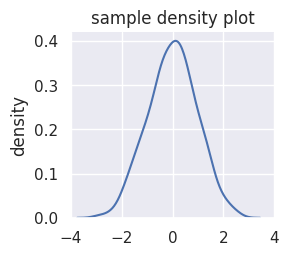

plot pdf


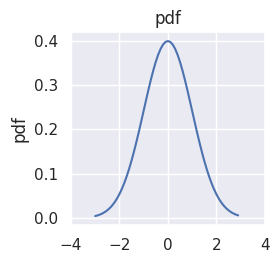

plot cdf


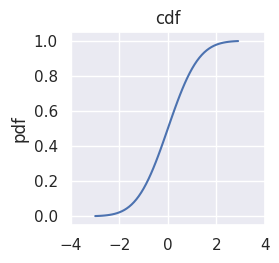

In [ ]:
import distrax

sz = 1000

print('normal distribution with mu = 0, sigma = 1')

key = jax.random.PRNGKey(1234)
mu = 0.0
sigma = 1.0

dist_normal = distrax.Normal(mu, sigma)

samples = dist_normal.sample(seed=key, sample_shape= sz)
print(f"sample size: {jnp.shape(samples)[0]}")
print(f"sample mean: {jnp.mean(samples)}")
print(f"sample var: {jnp.var(samples)}")
print(f"sample neg log prob: {-jnp.mean(dist_normal.log_prob(samples))}")

print("\nplot histogram/density")
sns.displot(samples, kind="kde", height=2.5, aspect = 1.2).set(xlabel="", ylabel="density", xlim=(-4, 4), title= "sample density plot")
plt.show()


values = jnp.arange(-3.0, 3.0, 0.1)
pdf = dist_normal.prob(values)
cdf = dist_normal.cdf(values)

sns.set(rc = {'figure.figsize':(2.5, 2.5)})
print("\nplot pdf")
sns.lineplot(x=values, y=pdf).set(xlabel="", ylabel="pdf", xlim=(-4, 4), title= "pdf")
plt.show()

print("\nplot cdf")
sns.lineplot(x=values, y=cdf).set(xlabel="", ylabel="pdf", xlim=(-4, 4), title= "cdf")
plt.show()


##Optax

Optax is a gradient processing and optimization library for JAX.  

It provides a consistent api to several well known optimizers, such as ADAM, RMSProp, SGD etc. 

In [ ]:
%%capture

!pip install optax

In [ ]:
from jax import random
from jax import numpy as jnp
import optax

jnp.set_printoptions(precision=3)

key = jax.random.PRNGKey(1234)

m = 5 
params = {'w': random.normal(key, (m,))}
n = 30
subkey1, subkey2, subkey3 = jax.random.split(key, num=3)
xs = random.normal(subkey1,(n, m))

key = jax.random.split(key)
ys = jnp.add(jnp.dot(xs, params['w']),
             0.1*random.normal(subkey2, (n,)))


compute_loss_single = lambda params, x, y: optax.l2_loss(params['w'].dot(x), y)
compute_loss = lambda params, xs, ys: jnp.sum(jax.vmap(compute_loss_single, in_axes=[None, 0, 0])(params, xs, ys))

print('original params ', params)
print('original loss ', compute_loss(params, xs, ys))

# create a stateful optimizer. 

optimizer = optax.adam(learning_rate=0.1)


params_init = {'w': random.normal(subkey3, (m,))}
opt_state = optimizer.init(params_init)
print('initial params ', params_init)
print('initial loss ', compute_loss(params_init, xs, ys))

# A simple update loop.
for iter in range(1000):
  grads = jax.grad(compute_loss)(params, xs, ys)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if iter % 5 == 0:
    print(f"loss at iteration {iter}:  {compute_loss(params, xs, ys)})


print('final params', params)
print('final loss ', compute_loss(params, xs, ys))
# print(params)
# assert jnp.allclose(params, target_params), \
# 'Optimization should retrive the target params used to generate the data.'

original params  {'w': Array([ 0.907, -0.945,  0.082, -1.844,  0.46 ], dtype=float32)}
original loss  0.11493597
initial params  {'w': Array([ 0.222, -2.844, -0.238, -0.578, -0.052], dtype=float32)}
initial loss  63.728706
final params {'w': Array([ 0.893, -0.941,  0.063, -1.813,  0.463], dtype=float32)}
final loss  0.0988175


# References



1. K. Murphy, Introduction to Jax. [link](https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/jax_intro.ipynb)
2. A. Steiner and K. Oliver, Jax - High-Performance ML Research [link](https://colab.research.google.com/drive/1jKgWswYZcoZs-f3a0ixdjLNioLN4Dud1)

